# This notebook contains code with sentence classificator HerBERT with fine-tuning.

In [ ]:
# Necessary imports and installations
import pandas as pd
import numpy as np
import random
!pip install transformers
import torch
from transformers import HerbertTokenizerFast, BertForMaskedLM, BertForSequenceClassification, pipeline
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

**Upload file named "data" in csv format with data. **


---













In [ ]:
df = pd.read_csv('/content/data.csv')

In [ ]:
df

,Treść,Kategoria
0,Księżna Diana i książę Karol pobrali się 39 la...,1
1,"Wielokrotnie zdradzana i niekochana Diana, któ...",1
2,Księżną Dianę po raz pierwszy zobaczył jesieni...,2
3,Ukończył Królewską Akademię Wojskową i został ...,2
4,"4 maja 2017 roku brytyjskie media donosiły, że...",2
...,...,...
2011,Jaguar wciąż nie atakował; cofnął się jeszcze ...,3
2012,Obaj przeciwnicy — król lasów i król mokradeł ...,3
2013,"Jaguar zamruczał zniecierpliwiony, skulił się ...",3
2014,"Kajman z kolei, zupełnie niefrasobliwy, świado...",3


In [ ]:
# Train, test and validation sets are prepared by selecting randomly, equal number of examples from each category.
df1 = df[df['Kategoria']==1].sample(frac=1)
df2 = df[df['Kategoria']==2].sample(frac=1)
df3 = df[df['Kategoria']==3].sample(frac=1)
df4 = df[df['Kategoria']==4].sample(frac=1)
df_train = pd.concat([df1[128:],df2[128:],df3[128:],df4[128:]]).sample(frac=1)
df_dev = pd.concat([df1[64:127],df2[64:127],df3[64:127],df4[64:127]]).sample(frac=1)
df_test = pd.concat([df1[:63],df2[:63],df3[:63],df4[:63]]).sample(frac=1)

## Data presentation 

In [ ]:
df_test

,Treść,Kategoria
1477,"Służący wyszedł z nim na korytarz, dotknął dzw...",2
245,Brał także udział w powstaniu kościuszkowskim.,1
19,"Mikołaj i Aleksandra zastanawiali się, czy bol...",2
15,17 lipca 1918 roku rodzina Mikołaja II została...,3
1417,"Pamiętam, że były tam porozstawiane działa prz...",2
...,...,...
1019,Powódź w 1897 roku wyrządziła straty przede ws...,3
2001,"Były to głównie wełniaki brunatne, mierzące od...",3
1112,Mieszkańcy miasta przemieszczali się z miejsca...,4
688,"Potem splądrowali mieszkanie, aby wyglądało na...",1


In [ ]:
df_train

,Treść,Kategoria
1356,Odkrycia dokonał poprzez zanurzenie w zakwaszo...,2
1337,Baldwin IV zaraził się trądem w wieku dziecięc...,2
435,Wściekły uderzył Jonesa z całej siły rękojeści...,1
1308,"Spojrzałam na twarze kobiet skupione, opanowan...",2
586,"Niedługo po wybuchu wojny, w maju 1915 r., zos...",2
...,...,...
1880,"Przez całą noc ryczał w pobliżu jaguar, a pies...",3
1725,"Miała zakaszlać się, tak jak bywało zwykle, il...",2
180,Opanowanie tego grodu uznał za kluczowe dla je...,2
364,"Ten widząc, że carowa domyśla się już czegoś, ...",2


In [ ]:
df_dev

,Treść,Kategoria
1476,Wokulski zaczął przeglądać listy.,2
859,W Hadze 3000 spadochroniarzy nie tylko nie po...,4
1268,"Niemcy ściągali coraz to większe posiłki, jed...",4
1353,Ofiara choroby kładzie się spać i śpi w dobrym...,2
24,Sam wybrał katów.,1
...,...,...
1572,"Tylko brwi jej ściągnęły się nad oczami, które...",3
1465,Wokulski pierwszy raz spostrzega dom trzypiętr...,2
724,"W 1956 r., już po przybyciu do Meksyku i pozna...",1
204,Mieszkańcy tego miasta z powodu upału w trakc...,4


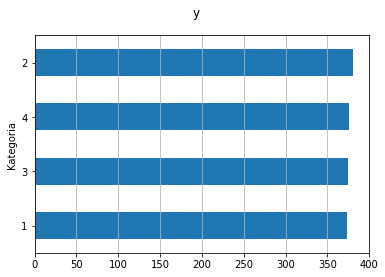

In [ ]:
# Train set
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_train["Kategoria"].reset_index().groupby("Kategoria").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

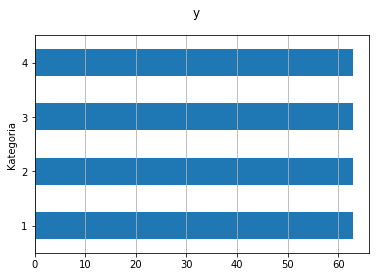

In [ ]:
# Test set
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_test["Kategoria"].reset_index().groupby("Kategoria").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

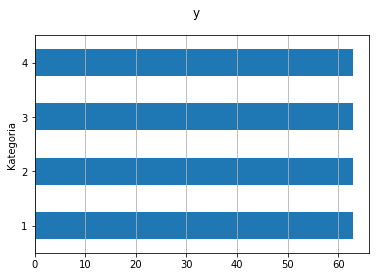

In [ ]:
# Validation set 
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
df_dev["Kategoria"].reset_index().groupby("Kategoria").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

## Preparing, training and evaluating 

In [ ]:
# This class loads and prepares data to fit criteria necessary to use BERT
class ARCorpus(Dataset):
  def __init__(self, train_df, val_df, test_df):
    self.label_dict = {1: 0, 2: 1, 3: 2, 4: 3}

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = HerbertTokenizerFast.from_pretrained('allegro/herbert-base-cased')
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)
    self.test_data = self.load_data(self.test_df)


  def load_data(self, df):
    MAX_LEN = 128
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    text_list = df['Treść'].to_list()
    label_list = df['Kategoria'].to_list()


    for (text, label) in zip(text_list, label_list):
      text_id = self.tokenizer.encode(text, add_special_tokens = False, max_length=510, truncation=True)
      pair_token_ids = [self.tokenizer.cls_token_id] + text_id + [self.tokenizer.sep_token_id]
      text_len = len(text_id)

      segment_ids = torch.tensor([0] * (text_len + 2) )  # text
      attention_mask_ids = torch.tensor([1] * (text_len + 2))

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    return dataset

  def get_data_loaders(self, batch_size=15, shuffle=True):
    # DataLoaders for trainig data, test data and validation data 
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    test_loader = DataLoader(
      self.test_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader, test_loader

In [ ]:
# Crates an objects with data prepared for classification 
train_loader, val_loader, test_loader = ARCorpus(df_train, df_dev, df_test).get_data_loaders()

In [ ]:
# Downloads a HerBERT model used for classification and optimizer
from transformers import AutoModelForSequenceClassification, AdamW 
model = AutoModelForSequenceClassification.from_pretrained("allegro/herbert-base-cased", num_labels=5).to('cuda')

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

In [ ]:
# Function for computing probability of predictions given labels
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [ ]:
# Train Function
import time
import copy

EPOCHS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, optimizer):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_epoch = 0

  for epoch in range(EPOCHS):
    start = time.time()
    # Setting model to training mode
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # Forward step
      # Returning loss and prediction in order to count the accuracy on dev set 
        
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()


      acc = multi_acc(prediction, labels)
    
      # Backward step
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    # Mean accuracy and loss in every batch
    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    # Setting model to evaluation mode
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0

    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()

    if val_acc > best_acc:
      best_acc = val_acc
      best_epoch = epoch
# Copying parameters of the best model
      best_model_wts = copy.deepcopy(model.state_dict())

    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best dev Acc: {:4f} in {} epoch'.format(best_acc, best_epoch+1))

# Loads and returns weights of the best model 
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
entailment_model = train(model, train_loader, val_loader, optimizer)

Epoch 1: train_loss: 1.1388 train_acc: 0.5795 | val_loss: 0.5889 val_acc: 0.8157
00:01:09.52
Epoch 2: train_loss: 0.4698 train_acc: 0.8530 | val_loss: 0.4146 val_acc: 0.8696
00:01:09.15
Epoch 3: train_loss: 0.2929 train_acc: 0.9069 | val_loss: 0.3645 val_acc: 0.8569
00:01:09.05
Epoch 4: train_loss: 0.1767 train_acc: 0.9512 | val_loss: 0.3522 val_acc: 0.8931
00:01:09.08

Training complete in 4m 37s
Best dev Acc: 0.893137 in 4 epoch


In [ ]:
# Evaluation on test set 

total_test_loss = 0
total_test_acc  = 0

labels_all = []
predictions_all = []
target_names = ["1", "2", "3", "4"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(test_loader):
  optimizer.zero_grad()
  pair_token_ids = pair_token_ids.to(device)
  mask_ids = mask_ids.to(device)
  seg_ids = seg_ids.to(device)
  labels = y.to(device)
  
  loss, prediction = entailment_model(pair_token_ids,
                           token_type_ids=seg_ids,
                           attention_mask=mask_ids,
                           labels=labels).values()

  acc = multi_acc(prediction, labels)

  total_test_loss += loss.item()
  total_test_acc  += acc.item()

  labels_all += [l.item() for l in labels]
  predictions_all += [p.item() for p in torch.log_softmax(prediction, dim=1).argmax(dim=1)]

test_acc  = total_test_acc/len(test_loader)
test_loss = total_test_loss/len(test_loader)

print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')

Test_loss: 0.3583 test_acc: 0.8784


In [ ]:
# Results


from sklearn.metrics import classification_report
print(classification_report(labels_all, predictions_all, target_names=target_names))

              precision    recall  f1-score   support

           1       0.82      0.92      0.87        63
           2       0.86      0.76      0.81        63
           3       0.90      0.90      0.90        63
           4       0.95      0.94      0.94        63

    accuracy                           0.88       252
   macro avg       0.88      0.88      0.88       252
weighted avg       0.88      0.88      0.88       252

